<a href="https://colab.research.google.com/github/MarcelaFerreiraR/Analise-de-dados-Anatel/blob/main/Cointegra%C3%A7%C3%A3o%20de%20A%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Baixar as bibliotecas
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
from datetime import datetime
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# URL do TradingView
url = "https://br.tradingview.com/markets/stocks-brazil/market-movers-active/"

# Ler a página (usando requests e BeautifulSoup)
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extrair tabelas (ajustar para encontrar a tabela correta, se necessário)
tables = pd.read_html(str(soup.find('table')))[0]  # Pegar a primeira tabela encontrada

# Selecionar colunas relevantes (Ticker e Setor, removendo Volume completamente)
dados = tables.iloc[:, [0, -2]].copy()  # Pegar colunas 0 (Ticker) e penúltima (Setor), removendo Volume
dados.columns = ['Ticker', 'Setor']  # Renomear colunas, excluindo Volume

# Função para extrair o ticker correto (4 letras + 1 número)
dados['Ticker'] = dados['Ticker'].str.extract(r'([A-Z]{4}[0-9])')

# Preencher dados vazios no Ticker com 'B3SA3'
dados['Ticker'] = dados['Ticker'].fillna('B3SA3')

# Lista de tickers limpos
tickers = dados['Ticker'].tolist()
tickers = [ticker + ".SA" for ticker in tickers]  # Adicionar ".SA" a cada ticker


<ipython-input-2-9ad9b7287a54>:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(str(soup.find('table')))[0]  # Pegar a primeira tabela encontrada


In [ ]:
# Baixar os dados do Yahoo Finance usando yfinance
end_date = datetime.now().date()
start_date = datetime(2022, 1, 1).date()
dados_acoes = yf.download(tickers, start=start_date, end=end_date)

# Verificar o estado inicial de dados_acoes antes de qualquer manipulação
print("\nEstado inicial de dados_acoes (colunas e índice):")
print("Colunas:", dados_acoes.columns)
print("Índice:", dados_acoes.index)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  100 of 100 completed


Estado inicial de dados_acoes (colunas e índice):
Colunas: MultiIndex([( 'Close', 'ABEV3.SA'),
            ( 'Close', 'ALOS3.SA'),
            ( 'Close', 'AMER3.SA'),
            ( 'Close', 'ANIM3.SA'),
            ( 'Close', 'ASAI3.SA'),
            ( 'Close', 'AURE3.SA'),
            ( 'Close', 'AZZA3.SA'),
            ( 'Close', 'B3SA3.SA'),
            ( 'Close', 'BBAS3.SA'),
            ( 'Close', 'BBDC3.SA'),
            ...
            ('Volume', 'TOTS3.SA'),
            ('Volume', 'UGPA3.SA'),
            ('Volume', 'VALE3.SA'),
            ('Volume', 'VAMO3.SA'),
            ('Volume', 'VBBR3.SA'),
            ('Volume', 'VIVA3.SA'),
            ('Volume', 'VIVT3.SA'),
            ('Volume', 'VULC3.SA'),
            ('Volume', 'WEGE3.SA'),
            ('Volume', 'YDUQ3.SA')],
           names=['Price', 'Ticker'], length=500)
Índice: DatetimeIndex(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07', '2022-01-10', '2022-01-11', '2022-01-12',
   

In [ ]:
print(dados_acoes.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 813 entries, 2022-01-03 to 2025-04-03
Columns: 500 entries, ('Close', 'ABEV3.SA') to ('Volume', 'YDUQ3.SA')
dtypes: float64(403), int64(97)
memory usage: 3.1 MB
None


In [ ]:
print(dados_acoes.head())

Price           Close                                                        \
Ticker       ABEV3.SA   ALOS3.SA     AMER3.SA  ANIM3.SA   ASAI3.SA AURE3.SA   
Date                                                                          
2022-01-03  13.447240  18.611378  3024.269775  6.953042  12.337970      NaN   
2022-01-04  13.429698  18.304499  2920.925781  6.514087  12.337970      NaN   
2022-01-05  13.166540  17.293598  2790.283691  6.127807  11.629893      NaN   
2022-01-06  12.956017  17.031847  2852.679932  6.241935  11.241907      NaN   
2022-01-07  12.745493  16.824249  2700.589111  6.233156  11.018815      NaN   

Price                                                   ...   Volume  \
Ticker       AZZA3.SA   B3SA3.SA   BBAS3.SA   BBDC3.SA  ... TOTS3.SA   
Date                                                    ...            
2022-01-03  66.620140   9.547424  11.367178  12.094121  ...  5585200   
2022-01-04  64.655571   9.752267  11.379011  12.150633  ...  4411900   
2022-01

In [ ]:
# Resetar o índice para tornar 'Date' uma coluna (mantendo 'Date' como coluna)
dados_acoes = dados_acoes.reset_index()

In [ ]:
print(dados_acoes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813 entries, 0 to 812
Columns: 502 entries, ('index', '') to ('Volume', 'YDUQ3.SA')
dtypes: datetime64[ns](1), float64(403), int64(98)
memory usage: 3.1 MB
None


In [ ]:
# Restaurar 'Date' como índice para facilitar a manipulação com stack
dados_acoes = dados_acoes.set_index(('Date', ''))

# Usar stack para transformar de wide para long, mantendo o MultiIndex nas colunas
dados_long = dados_acoes.stack(level='Ticker')

# Resetar o índice para ter todas as variáveis como colunas
dados_long = dados_long.reset_index()

<ipython-input-9-423a042dea48>:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  dados_long = dados_acoes.stack(level='Ticker')


In [ ]:
print(dados_long.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82051 entries, 0 to 82050
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   (Date, )  82051 non-null  datetime64[ns]
 1   Ticker    82051 non-null  object        
 2   index     813 non-null    float64       
 3   Close     81238 non-null  float64       
 4   High      81238 non-null  float64       
 5   Low       81238 non-null  float64       
 6   Open      81238 non-null  float64       
 7   Volume    81238 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 5.0+ MB
None


In [ ]:
print(dados_long.head())

Price   (Date, )    Ticker  index        Close         High          Low  \
0     2022-01-03  ABEV3.SA    NaN    13.447240    13.631449    13.289346   
1     2022-01-03  ALOS3.SA    NaN    18.611378    19.838897    18.485014   
2     2022-01-03  AMER3.SA    NaN  3024.269775  3084.716059  2857.554674   
3     2022-01-03  ANIM3.SA    NaN     6.953042     7.444670     6.953042   
4     2022-01-03  ASAI3.SA    NaN    12.337970    12.687157    12.027580   

Price         Open      Volume  
0        13.526187  23833600.0  
1        19.748638   1241800.0  
2      3052.543188     76374.0  
3         7.418333   2190100.0  
4        12.687157  16124600.0  


In [ ]:
# Verificar o resultado
print("\nDataFrame após stack e reset_index (long format):")
print(dados_long.head())
print("Colunas após transformação:", dados_long.columns)


DataFrame após stack e reset_index (long format):
Price   (Date, )    Ticker  index        Close         High          Low  \
0     2022-01-03  ABEV3.SA    NaN    13.447240    13.631449    13.289346   
1     2022-01-03  ALOS3.SA    NaN    18.611378    19.838897    18.485014   
2     2022-01-03  AMER3.SA    NaN  3024.269775  3084.716059  2857.554674   
3     2022-01-03  ANIM3.SA    NaN     6.953042     7.444670     6.953042   
4     2022-01-03  ASAI3.SA    NaN    12.337970    12.687157    12.027580   

Price         Open      Volume  
0        13.526187  23833600.0  
1        19.748638   1241800.0  
2      3052.543188     76374.0  
3         7.418333   2190100.0  
4        12.687157  16124600.0  
Colunas após transformação: Index([('Date', ''), 'Ticker', 'index', 'Close', 'High', 'Low', 'Open',
       'Volume'],
      dtype='object', name='Price')


In [ ]:
dados_long.columns = [col[0] if isinstance(col, tuple) else col for col in dados_long.columns]

In [ ]:
dados_long = dados_long.rename(columns={"Date": "date"})
dados_long = dados_long.rename(columns={'Ticker': 'acao'})

In [ ]:
# Converter a coluna 'Date' para o formato Date
dados_long['date'] = pd.to_datetime(dados_long['date'])

# Criar colunas de período
dados_long['dia'] = dados_long['date'].dt.date  # Dia (data completa)
dados_long['semana'] = dados_long['date'].dt.strftime('%U/%Y')  # Semana (WW/YY)
dados_long['quinzenal'] = dados_long['date'].apply(lambda x: f"{x.day <= 15 and '01' or '16'}/{x.year}")  # Quinzena (01 ou 16/ano)
dados_long['mes'] = dados_long['date'].dt.strftime('%b')  # Mês (MM/YY)
dados_long['ano'] = dados_long['date'].dt.strftime('%Y')  # Ano

print(dados_long.head())

        date      acao  index        Close         High          Low  \
0 2022-01-03  ABEV3.SA    NaN    13.447240    13.631449    13.289346   
1 2022-01-03  ALOS3.SA    NaN    18.611378    19.838897    18.485014   
2 2022-01-03  AMER3.SA    NaN  3024.269775  3084.716059  2857.554674   
3 2022-01-03  ANIM3.SA    NaN     6.953042     7.444670     6.953042   
4 2022-01-03  ASAI3.SA    NaN    12.337970    12.687157    12.027580   

          Open      Volume         dia   semana quinzenal  mes   ano  
0    13.526187  23833600.0  2022-01-03  01/2022   01/2022  Jan  2022  
1    19.748638   1241800.0  2022-01-03  01/2022   01/2022  Jan  2022  
2  3052.543188     76374.0  2022-01-03  01/2022   01/2022  Jan  2022  
3     7.418333   2190100.0  2022-01-03  01/2022   01/2022  Jan  2022  
4    12.687157  16124600.0  2022-01-03  01/2022   01/2022  Jan  2022  


In [ ]:
# Verificar o resultado
print("\nDataFrame após stack e reset_index (long format):")
print(dados_long.head())
print("Colunas após transformação:", dados_long.columns)


DataFrame após stack e reset_index (long format):
        date      acao  index        Close         High          Low  \
0 2022-01-03  ABEV3.SA    NaN    13.447240    13.631449    13.289346   
1 2022-01-03  ALOS3.SA    NaN    18.611378    19.838897    18.485014   
2 2022-01-03  AMER3.SA    NaN  3024.269775  3084.716059  2857.554674   
3 2022-01-03  ANIM3.SA    NaN     6.953042     7.444670     6.953042   
4 2022-01-03  ASAI3.SA    NaN    12.337970    12.687157    12.027580   

          Open      Volume         dia   semana quinzenal  mes   ano  
0    13.526187  23833600.0  2022-01-03  01/2022   01/2022  Jan  2022  
1    19.748638   1241800.0  2022-01-03  01/2022   01/2022  Jan  2022  
2  3052.543188     76374.0  2022-01-03  01/2022   01/2022  Jan  2022  
3     7.418333   2190100.0  2022-01-03  01/2022   01/2022  Jan  2022  
4    12.687157  16124600.0  2022-01-03  01/2022   01/2022  Jan  2022  
Colunas após transformação: Index(['date', 'acao', 'index', 'Close', 'High', 'Low', 'Open'

In [ ]:
# Verificar novamente após o filtro para VALE3.SA
print("\nDataFrame após filtro para 'Close' e conversão para VALE3.SA:")
print(dados_long[dados_long['acao'] == 'VALE3.SA']['date'].head(10))
print("Número de dias únicos para VALE3.SA após filtro:", dados_long[dados_long['acao'] == 'VALE3.SA']['date'].nunique())
print("Gaps detectados em VALE3.SA após filtro:")
dates = dados_long[dados_long['acao'] == 'VALE3.SA']['date'].sort_values()
gaps = dates.diff().dt.days > 1
print(dates[gaps])


DataFrame após filtro para 'Close' e conversão para VALE3.SA:
91    2022-01-03
191   2022-01-04
291   2022-01-05
391   2022-01-06
491   2022-01-07
591   2022-01-10
691   2022-01-11
791   2022-01-12
891   2022-01-13
991   2022-01-14
Name: date, dtype: datetime64[ns]
Número de dias únicos para VALE3.SA após filtro: 813
Gaps detectados em VALE3.SA após filtro:
591     2022-01-10
1091    2022-01-17
1591    2022-01-24
2091    2022-01-31
2591    2022-02-07
           ...    
79921   2025-03-05
80224   2025-03-10
80729   2025-03-17
81234   2025-03-24
81739   2025-03-31
Name: date, Length: 185, dtype: datetime64[ns]


In [ ]:
# Ordenar dados_long por 'date' e 'acao' para garantir consecutividade
dados_long = dados_long.sort_values(['date', 'acao'])

# Verificar o número de dias por ticker antes de calcular os retornos
print("\nNúmero de dias por ticker em 'dados_long':")
for ticker in tickers:
    days_count = dados_long[dados_long['acao'] == ticker]['date'].nunique()
    print(f"{ticker}: {days_count} dias únicos")


Número de dias por ticker em 'dados_long':
VALE3.SA: 813 dias únicos
PRIO3.SA: 813 dias únicos
BRAV3.SA: 811 dias únicos
PETR3.SA: 813 dias únicos
MGLU3.SA: 813 dias únicos
EMBR3.SA: 813 dias únicos
WEGE3.SA: 813 dias únicos
ABEV3.SA: 813 dias únicos
ELET3.SA: 813 dias únicos
BBAS3.SA: 813 dias únicos
SBSP3.SA: 813 dias únicos
B3SA3.SA: 813 dias únicos
RENT3.SA: 813 dias únicos
SUZB3.SA: 813 dias únicos
JBSS3.SA: 813 dias únicos
CRFB3.SA: 813 dias únicos
RAIL3.SA: 813 dias únicos
LREN3.SA: 813 dias únicos
VBBR3.SA: 813 dias únicos
COGN3.SA: 813 dias únicos
TIMS3.SA: 813 dias únicos
CCRO3.SA: 813 dias únicos
BRFS3.SA: 813 dias únicos
CSAN3.SA: 813 dias únicos
RADL3.SA: 813 dias únicos
EQTL3.SA: 813 dias únicos
HAPV3.SA: 813 dias únicos
CSNA3.SA: 813 dias únicos
CYRE3.SA: 813 dias únicos
BHIA3.SA: 813 dias únicos
BBSE3.SA: 813 dias únicos
SLCE3.SA: 813 dias únicos
RECV3.SA: 813 dias únicos
RDOR3.SA: 813 dias únicos
MRFG3.SA: 813 dias únicos
NTCO3.SA: 813 dias únicos
UGPA3.SA: 813 dias ú

In [ ]:
# Análise detalhada dos valores vazios na coluna Retorno_ticker (para depuração, mas não impacta o resultado final)
print("Quantidade de valores NaN em 'Retorno_ticker':", dados_long.isna().sum())
print("Porcentagem de valores NaN em 'Retorno_ticker':", (dados_long.isna().sum() / len(dados_long)) * 100, "%")

Quantidade de valores NaN em 'Retorno_ticker': date             0
acao             0
index        81238
Close          813
High           813
Low            813
Open           813
Volume         813
dia              0
semana           0
quinzenal        0
mes              0
ano              0
dtype: int64
Porcentagem de valores NaN em 'Retorno_ticker': date          0.000000
acao          0.000000
index        99.009153
Close         0.990847
High          0.990847
Low           0.990847
Open          0.990847
Volume        0.990847
dia           0.000000
semana        0.000000
quinzenal     0.000000
mes           0.000000
ano           0.000000
dtype: float64 %


In [ ]:
print(dados_long.info())

<class 'pandas.core.frame.DataFrame'>
Index: 82051 entries, 99 to 82049
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       82051 non-null  datetime64[ns]
 1   acao       82051 non-null  object        
 2   index      813 non-null    float64       
 3   Close      81238 non-null  float64       
 4   High       81238 non-null  float64       
 5   Low        81238 non-null  float64       
 6   Open       81238 non-null  float64       
 7   Volume     81238 non-null  float64       
 8   dia        82051 non-null  object        
 9   semana     82051 non-null  object        
 10  quinzenal  82051 non-null  object        
 11  mes        82051 non-null  object        
 12  ano        82051 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(6)
memory usage: 8.8+ MB
None


In [ ]:
# Usar Close para cálculos de retorno
dados_long['retorno'] = dados_long.groupby('acao')['Close'].transform(lambda x: x.pct_change() * 100)

<ipython-input-21-d649ddbe4450>:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  dados_long['retorno'] = dados_long.groupby('acao')['Close'].transform(lambda x: x.pct_change() * 100)


In [ ]:
print(dados_long.info())
print(dados_long.head())

<class 'pandas.core.frame.DataFrame'>
Index: 82051 entries, 99 to 82049
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       82051 non-null  datetime64[ns]
 1   acao       82051 non-null  object        
 2   index      813 non-null    float64       
 3   Close      81238 non-null  float64       
 4   High       81238 non-null  float64       
 5   Low        81238 non-null  float64       
 6   Open       81238 non-null  float64       
 7   Volume     81238 non-null  float64       
 8   dia        82051 non-null  object        
 9   semana     82051 non-null  object        
 10  quinzenal  82051 non-null  object        
 11  mes        82051 non-null  object        
 12  ano        82051 non-null  object        
 13  retorno    81138 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(6)
memory usage: 9.4+ MB
None
         date      acao  index        Close         High          L

In [ ]:
print(dados_long.retorno.tail())

82045    3.000002
82046    1.865887
82047   -0.125075
82048   -1.403120
82049    3.781169
Name: retorno, dtype: float64


In [ ]:
def analisar_pares(acao1, acao2, dados):
    """
    Função para análise de pares de ativos (Long & Short)

    Parâmetros:
    - acao1: Primeiro ativo para análise
    - acao2: Segundo ativo para análise
    - dados: DataFrame com colunas 'date', 'acao', 'retorno'
    """
    try:
        # Pivotear os dados para ter retornos por ação
        df = dados.pivot(index='date', columns='acao', values='retorno')

        # Verificar se as ações existem no DataFrame
        if acao1 not in df.columns or acao2 not in df.columns:
            raise ValueError(f"Erro: {acao1} ou {acao2} não encontradas nos dados!")

        # Remover valores NaN
        df_filtrado = df[[acao1, acao2]].dropna()

        # Correlação
        correlacao = df_filtrado[acao1].corr(df_filtrado[acao2])
        print(f"Correlação entre {acao1} e {acao2}: {correlacao:.4f}")

        # Beta
        X = sm.add_constant(df_filtrado[acao2])
        y = df_filtrado[acao1]
        model = sm.OLS(y, X).fit()
        beta = model.params[acao2]
        print(f"Beta de {acao1} em relação a {acao2}: {beta:.4f}")

        # Teste de Cointegração
        score, p_value, _ = coint(df_filtrado[acao1], df_filtrado[acao2])
        print(f"Teste de Cointegração p-value: {p_value:.4f}")

        # Plotar Spread
        spread = df_filtrado[acao1] - beta * df_filtrado[acao2]
        plt.figure(figsize=(12, 6))
        plt.plot(df_filtrado.index, spread, label="Spread")
        plt.axhline(spread.mean(), color='red', linestyle='--', label="Média do Spread")
        plt.title(f"Spread entre {acao1} e {acao2}")
        plt.xlabel("Data")
        plt.ylabel("Spread")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Retornar métricas adicionais
        return {
            'correlacao': correlacao,
            'beta': beta,
            'p_value_coint': p_value,
            'spread_mean': spread.mean(),
            'spread_std': spread.std()
        }

    except Exception as e:
        print(f"Erro na análise de pares: {e}")
        return None

Correlação entre ANIM3.SA e ASAI3.SA: 0.4230
Beta de ANIM3.SA em relação a ASAI3.SA: 0.6546
Teste de Cointegração p-value: 0.0000


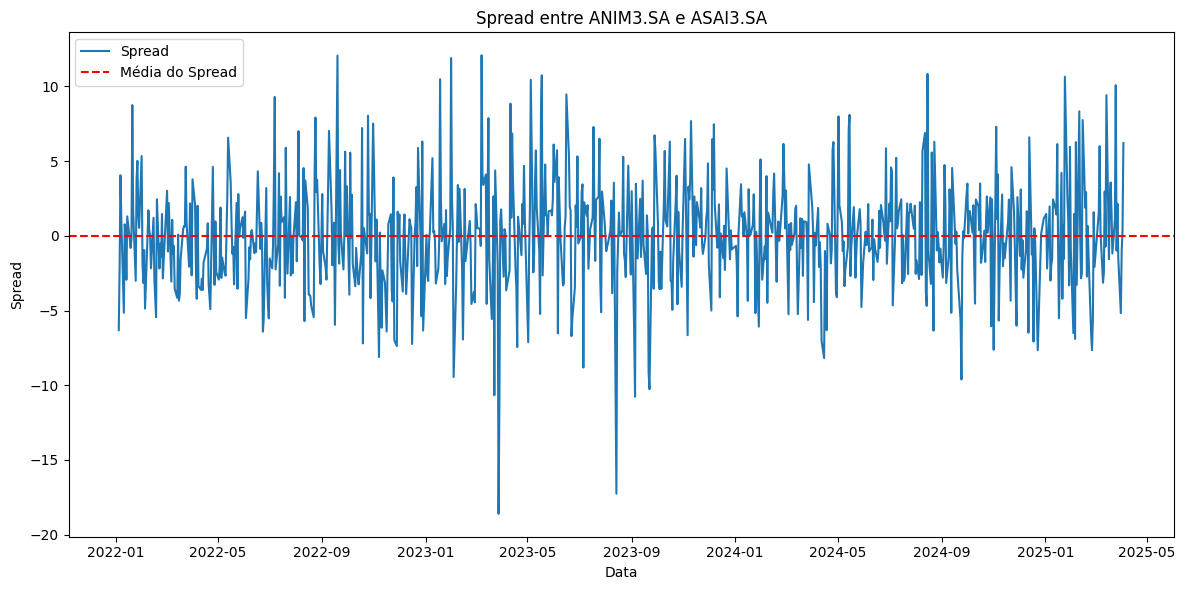

In [ ]:
# Supondo que você tenha um DataFrame chamado 'dados_acoes'
resultado = analisar_pares('ANIM3.SA', 'ASAI3.SA', dados_long)
